In [1]:
from pathlib import Path
import numpy as np
from crawfish.utils.testing import EXAMPLE_CALC_DIRS_DIR
from crawfish.core.operations.vector import get_gauss_smear_spectrum, get_lti_spectrum,get_uneven_integrated_array
from crawfish.core.elecdata import ElecData, los_projs_for_bands
from crawfish.funcs.general import SIGMA_DEFAULT, RES_DEFAULT
from crawfish.utils.typing import REAL_DTYPE, cs_formatter, COMPLEX_DTYPE
import matplotlib.pyplot as plt

n2_calcdir = EXAMPLE_CALC_DIRS_DIR / "N2_bare_min"
edata = ElecData(n2_calcdir)
#edata.norm_projs_t2()
nproj = edata.nproj
nspin = edata.nspin
nbands = edata.nbands
nstates = edata.nstates
kfolding = edata.kfolding
nk = np.prod(kfolding)
proj_sabcju = edata.proj_sabcju
e_sabcj = edata.e_sabcj
occ_sabcj = edata.occ_sabcj
wk_jsabc = np.array([edata.wk_sabc for _ in range(nbands)], dtype=REAL_DTYPE)
wk_sabcj = np.moveaxis(wk_jsabc, 0, -1)

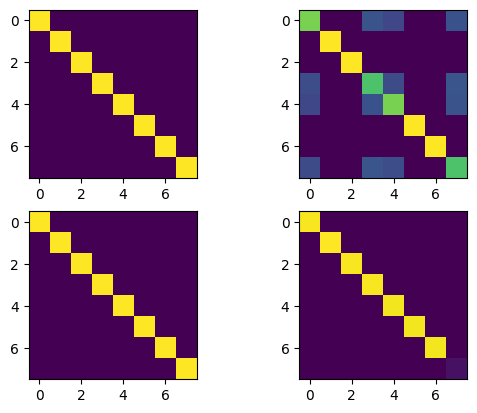

In [2]:

def _norm_projs_for_bands_jit_helper_1(nProj, nStates, nBands, proj_tju, j_sums):
    for u in range(nProj):
        for t in range(nStates):
            for j in range(nBands):
                j_sums[j] += abs(np.conj(proj_tju[t, j, u]) * proj_tju[t, j, u])
    for j in range(nBands):
        proj_tju[:, j, :] *= 1 / np.sqrt(j_sums[j])
    proj_tju *= np.sqrt(nStates)
    return proj_tju


def _norm_projs_for_bands(proj_tju, nStates, nBands, nProj):
    j_sums = np.zeros(nBands)
    proj_tju = _norm_projs_for_bands_jit_helper_1(nProj, nStates, nBands, proj_tju, j_sums)
    return proj_tju

def _norm_projs_for_orbs_jit_helper(nProj, nStates, nBands, proj_tju, u_sums):
    for u in range(nProj):
        for t in range(nStates):
            for j in range(nBands):
                u_sums[u] += abs(np.conj(proj_tju[t, j, u]) * proj_tju[t, j, u])
    for u in range(nProj):
        proj_tju[:, :, u] *= 1 / np.sqrt(u_sums[u])
    proj_tju *= np.sqrt(nStates)
    # proj_tju *= np.sqrt(2)
    # proj_tju *= np.sqrt(nStates*nBands/nProj)
    return proj_tju


def _norm_projs_for_orbs(proj_tju, nStates, nBands, nProj):
    u_sums = np.zeros(nProj)
    # TODO: Identify the error types raised by division by zero within a jitted function
    # (if certain orbitals are only represented by bands above nProj, this error should
    # be clarified to the user)
    proj_tju = _norm_projs_for_orbs_jit_helper(nProj, nStates, nBands, proj_tju, u_sums)
    return proj_tju

def los_projs_for_orbs_t2(edata):
    e_sabcj = edata.e_sabcj[:,:,:,:,:nproj]
    proj_sabcju = edata.proj_sabcju[:,:,:,:,:nproj, :]
    low_proj_sabcju = np.zeros(proj_sabcju.shape, dtype=COMPLEX_DTYPE)

    nka = kfolding[0]
    nkb = kfolding[1]
    nkc = kfolding[2]
    s_uu_sabc = np.zeros([nproj, nproj, nspin] + list(kfolding), dtype=COMPLEX_DTYPE)
    for s in range(nspin):
        for a in range(nka):
            for b in range(nkb):
                for c in range(nkc):
                    s_uu_sabc[:,:,s,a,b,c] = np.tensordot(
                        proj_sabcju[s,a,b,c].conj().T,
                        proj_sabcju[s,a,b,c],
                        axes=(
                            [1],
                            [0]
                        )
                    )
    for s in range(nspin):
        for a in range(nka):
            for b in range(nkb):
                for c in range(nkc):
                    s_uu = s_uu_sabc[:,:,s,a,b,c]
                    eigs, low_u = np.linalg.eigh(s_uu)
                    nsqrt_ss_uu = np.eye(len(eigs)) * (eigs ** (-0.5))
                    low_s_uu = np.dot(low_u, np.dot(nsqrt_ss_uu, low_u.T.conj()))
                    low_proj_ju = np.tensordot(proj_sabcju[s,a,b,c], low_s_uu, axes=([1], [0]))
                    low_proj_sabcju[s,a,b,c] = low_proj_ju.conj().T

    return e_sabcj, low_proj_sabcju




def los_projs_for_orbs(_proj_sabcju: np.ndarray[COMPLEX_DTYPE], mute_xs_bands=False) -> np.ndarray[COMPLEX_DTYPE]:
    """Perform LOS on projections for orb orthogonality.

    Perform Lowdin symmetric orthogonalization on projections for orb orthogonality.

    Parameters
    ----------
    proj_sabcju : np.ndarray[COMPLEX_DTYPE]
        Projections in shape (nstates, nbands, nproj).
    """
    proj_sabcju = _proj_sabcju.copy()
    sabcju = np.shape(proj_sabcju)
    nstates = np.prod(np.shape(proj_sabcju)[:-2])
    nbands = np.shape(proj_sabcju)[-2]
    nproj = np.shape(proj_sabcju)[-1]
    proj_tju = proj_sabcju.reshape(nstates, nbands, nproj)
    proj_tju = _norm_projs_for_orbs(proj_tju, nstates, nbands, nproj)
    proj_sabcju = proj_tju.reshape(sabcju)
    s_uu = np.tensordot(proj_sabcju.conj().T, proj_sabcju, axes=([5, 4, 3, 2, 1], [0, 1, 2, 3, 4]))
    eigs, low_u = np.linalg.eigh(s_uu)
    nsqrt_ss_uu = np.eye(len(eigs)) * (eigs ** (-0.5))
    low_s_uu = np.dot(low_u, np.dot(nsqrt_ss_uu, low_u.T.conj()))
    low_proj_sabcju = np.tensordot(proj_sabcju, low_s_uu, axes=([5], [0]))
    proj_tju = low_proj_sabcju.reshape(nstates, nbands, nproj)
    proj_tju = _norm_projs_for_orbs(proj_tju, nstates, nbands, nproj)
    low_proj_sabcju = proj_tju.reshape(sabcju)
    return low_proj_sabcju

def los_projs_for_bands(_proj_sabcju: np.ndarray[COMPLEX_DTYPE]) -> np.ndarray[COMPLEX_DTYPE]:
    """Perform LOS on projections for band orthogonality.

    Perform Lowdin symmetric orthogonalization on projections for band orthogonality.

    Parameters
    ----------
    proj_sabcju : np.ndarray[COMPLEX_DTYPE]
        Projections in shape (nstates, nbands, nproj).
    """
    proj_sabcju = _proj_sabcju.copy()
    sabcju = np.shape(proj_sabcju)
    nstates = np.prod(np.shape(proj_sabcju)[:-2])
    nbands = np.shape(proj_sabcju)[-2]
    nproj = np.shape(proj_sabcju)[-1]
    s_jj = np.tensordot(proj_sabcju.conj().T, proj_sabcju, axes=([5, 4, 3, 2, 0], [0, 1, 2, 3, 5]))
    eigs, low_u = np.linalg.eigh(s_jj)
    nsqrt_ss_jj = np.eye(len(eigs)) * (eigs ** (-0.5))
    low_s_jj = np.dot(low_u, np.dot(nsqrt_ss_jj, low_u.T.conj()))
    low_proj_sabcju = np.tensordot(proj_sabcju, low_s_jj, axes=([4], [0]))
    low_proj_sabcju = np.swapaxes(low_proj_sabcju, 5, 4)
    proj_tju = low_proj_sabcju.reshape(nstates, nbands, nproj)
    proj_tju = _norm_projs_for_bands(proj_tju, nstates, nbands, nproj)
    low_proj_sabcju = proj_tju.reshape(sabcju)
    return low_proj_sabcju


e_sabcj = e_sabcj[:,:,:,:,:nproj]
proj_sabcju = proj_sabcju[:,:,:,:,:nproj, :]
occ_sabcj = occ_sabcj[:,:,:,:,:nproj]
wk_sabcj = wk_sabcj[:,:,:,:,:nproj]

low_proj_sabcju_t2 = los_projs_for_bands(proj_sabcju) 
low_proj_sabcju = los_projs_for_orbs(proj_sabcju) 
#low_proj_sabcju *= 1/np.sqrt(nstates)

fig, ax = plt.subplots(nrows=2, ncols=2)
LULU = np.tensordot(low_proj_sabcju.conj().T, low_proj_sabcju, axes=([5, 4, 3, 2, 1], [0, 1, 2, 3, 4]))
ULU = np.tensordot(proj_sabcju.conj().T, low_proj_sabcju, axes=([5, 4, 3, 2, 1], [0, 1, 2, 3, 4]))
LJLJ = np.tensordot(low_proj_sabcju_t2.conj().T, low_proj_sabcju_t2, axes=([5, 4,3,2,0], [0, 1, 2, 3, 5]))
JLJ = np.tensordot(proj_sabcju.conj().T, low_proj_sabcju_t2, axes=([5, 4, 3, 2, 0], [0, 1, 2, 3, 5]))
ax[0,0].imshow(np.abs(LULU))
ax[0,1].imshow(np.abs(ULU))
ax[1,0].imshow(np.abs(LJLJ))
ax[1,1].imshow(np.abs(JLJ))


0.8363785920319734
45.16444396972656


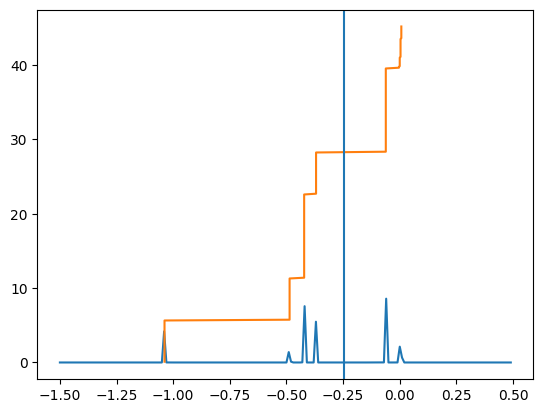

In [9]:
erange = np.arange(-1.5, 0.5, RES_DEFAULT, dtype=REAL_DTYPE)
us = [0,1,2,3]
vs = [4,5,6,7]
orbs = us + vs

# edata = ElecData(n2_calcdir)
# edata.norm_projs_t1()
# e_sabcj = edata.e_sabcj.copy()
# low_proj_sabcju = edata.proj_sabcju.copy()

# p1 = np.zeros(np.shape(e_sabcj), dtype=COMPLEX_DTYPE)
# p2 = np.zeros(np.shape(e_sabcj), dtype=COMPLEX_DTYPE)
# for u in us:
#     p1 += low_proj_sabcju[:,:,:,:,:,u]*np.sum(S_UU[u])
# for v in vs:
#     p2 += low_proj_sabcju[:,:,:,:,:,v]*np.sum(S_UU[v])

# weights_sabcj = p1.conj() * p2 + p2.conj() * p1
h_uv_sabcj = np.zeros([nproj, nproj] + list(np.shape(e_sabcj)), dtype=COMPLEX_DTYPE)
p_uv_sabcj = np.zeros([nproj, nproj] + list(np.shape(e_sabcj)), dtype=COMPLEX_DTYPE)
s_uv_sabcj = np.zeros([nproj, nproj] + list(np.shape(e_sabcj)), dtype=COMPLEX_DTYPE)
l_uv_sabcj = np.zeros([nproj, nproj] + list(np.shape(e_sabcj)), dtype=COMPLEX_DTYPE)
weights_sabcj = np.zeros(np.shape(e_sabcj), dtype=COMPLEX_DTYPE)

nspin, nka, nkb, nkc, nbands = np.shape(weights_sabcj)

for u in orbs:
    for v in orbs:
        # part_sabcj = low_proj_sabcju[:,:,:,:,:,u].conj() * low_proj_sabcju[:,:,:,:,:,v] * S_UU[u,v]
        part_sabcj = low_proj_sabcju[:,:,:,:,:,u].conj() * low_proj_sabcju[:,:,:,:,:,v]
        part_sabcj += part_sabcj.conj()
        part_sabcj *= 0.5 * wk_sabcj
        p_uv_sabcj[u,v, :, :, :, :, :] += part_sabcj
        # part_sabcj = np.real(low_proj_sabcju[:,:,:,:,:,u].conj() * low_proj_sabcju[:,:,:,:,:,v])
        huv_sabc = np.zeros([nspin] + list(kfolding), dtype=COMPLEX_DTYPE)
        for s in range(nspin):
            for a in range(nka):
                for b in range(nkb):
                    for c in range(nkc):
                        for j in range(np.shape(weights_sabcj)[-1]):
                            huv_sabc[s,a,b,c] += part_sabcj[s,a,b,c,j]*e_sabcj[s,a,b,c,j]
        huv_jsabc = np.array([huv_sabc for j in range(np.shape(weights_sabcj)[-1])], dtype=COMPLEX_DTYPE)
        huv_sabcj = np.moveaxis(huv_jsabc, 0, -1)
        h_uv_sabcj[u,v, :, :, :, :, :] += huv_sabcj
        part2_sabcj = low_proj_sabcju_t2[:,:,:,:,:,u].conj() * low_proj_sabcju_t2[:,:,:,:,:,v]
        part2_sabcj += part2_sabcj.conj()
        part2_sabcj *= 0.5
        suv_sabc = np.sum(part2_sabcj, axis=-1)
        suv_jsabc = np.array([suv_sabc for j in range(np.shape(weights_sabcj)[-1])], dtype=COMPLEX_DTYPE)
        suv_sabcj = np.moveaxis(suv_jsabc, 0, -1)
        s_uv_sabcj[u,v, :, :, :, :, :] += abs(suv_sabcj)
        luv_sabc = np.zeros([nspin] + list(kfolding), dtype=COMPLEX_DTYPE)
        for s in range(nspin):
            for a in range(nka):
                for b in range(nkb):
                    for c in range(nkc):
                        for j in range(np.shape(weights_sabcj)[-1]):
                            luv_sabc[s,a,b,c] += part2_sabcj[s,a,b,c,j]
        luv_jsabc = np.array([luv_sabc for j in range(np.shape(weights_sabcj)[-1])], dtype=COMPLEX_DTYPE)
        luv_sabcj = np.moveaxis(luv_jsabc, 0, -1)
        l_uv_sabcj[u,v, :, :, :, :, :] += luv_sabcj
        # huv_jsabc = np.array([huv_sabc for j in range(np.shape(weights_sabcj)[-1])], dtype=COMPLEX_DTYPE)
        # huv_sabcj = np.moveaxis(huv_jsabc, 0, -1)
        # if (u in us) and (v in vs):
        #     # weights_sabcj += (part_sabcj + part_sabcj.conj())*0.5
        #     weights_sabcj += part_sabcj
        # weights_sabcj += part_sabcj * huv_sabcj
        # weights_sabcj += part_sabcj * suv_sabcj
        # weights_sabcj += part_sabcj

def plot_weights(e_sabcj, weights_sabcj, ax):
    cs = get_gauss_smear_spectrum(erange, e_sabcj, weights_sabcj, SIGMA_DEFAULT)
    spectrum = cs_formatter(cs, False)
    ax.plot(erange, spectrum)
    es, integs = get_uneven_integrated_array(e_sabcj, weights_sabcj)
    ax.plot(es, integs)
    print(f"{integs[-1]/(np.prod(kfolding)*nspin)}")
    print(f"{integs[np.argsort(abs(integs))[-1]]}")

fig, ax = plt.subplots()



weights_sabcj = np.zeros(np.shape(e_sabcj), dtype=REAL_DTYPE)
# p_uv_sabcj[:,:] *= 1/(nstates**(1/4))
for i, u in enumerate(orbs):
    for v in orbs[i+1:]:
# for u in [0, 3]:
#     for s in [4, 7]:
        weights_sabcj += np.real(
            h_uv_sabcj[u,v,:,:,:,:,:]*np.sum(
                h_uv_sabcj[u,v,:,:,:,:,:], axis=(0,1,2,3,4)
                )
            )
plot_weights(e_sabcj, np.real(weights_sabcj*REAL_DTYPE(1)), ax)
# plot_weights(e_sabcj, occ_sabcj*wk_sabcj, ax)

ax.axvline(edata.mu)

In [394]:
np.sum(low_proj_sabcju.conj() * low_proj_sabcju, axis=(0,1,2,3,5))

array([0.99986352-8.00551895e-19j, 1.00000882-9.93308999e-19j,
       0.99993631-1.22215534e-18j, 0.99993323+3.09529317e-18j,
       0.99894971+6.20285976e-19j, 0.9999726 -4.00369561e-18j,
       0.99999964-7.39539240e-19j, 1.00133616+5.11258367e-19j])

In [391]:
nelecs_j = np.sum(occ_sabcj*wk_sabcj, axis=(0,1,2,3))
print(nelecs_j)

[1.9999992e+00 1.9999992e+00 1.9999992e+00 1.9999992e+00 1.9999992e+00
 3.0448893e-15 2.9976022e-15 0.0000000e+00]


In [386]:
2.5*4

10.0

In [385]:
2/0.5

4.0